In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

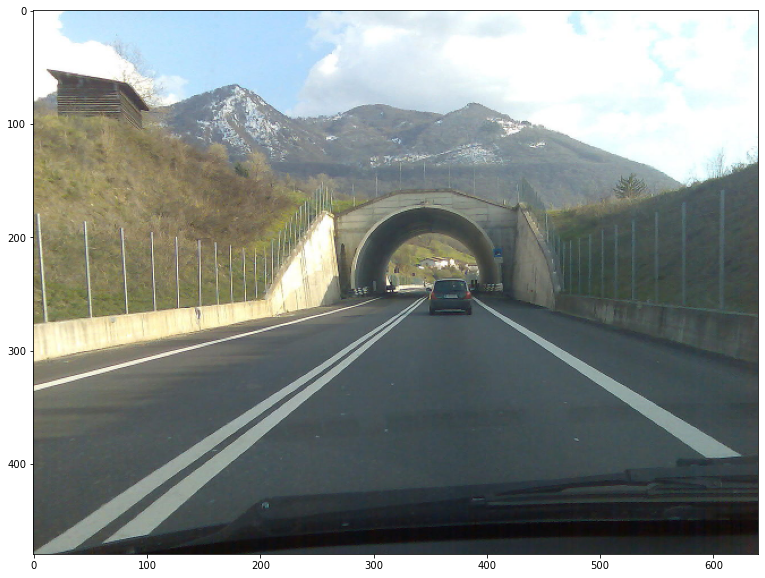

In [2]:
img = cv2.imread('../Data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [3]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [107]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:250] = 0

(<AxesSubplot:title={'center':'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

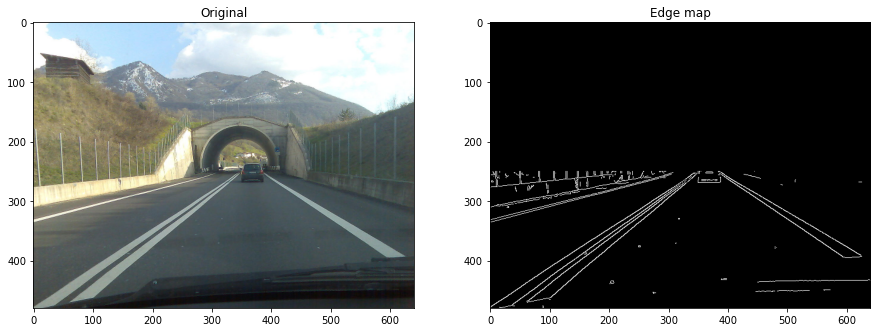

In [108]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [129]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)

# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

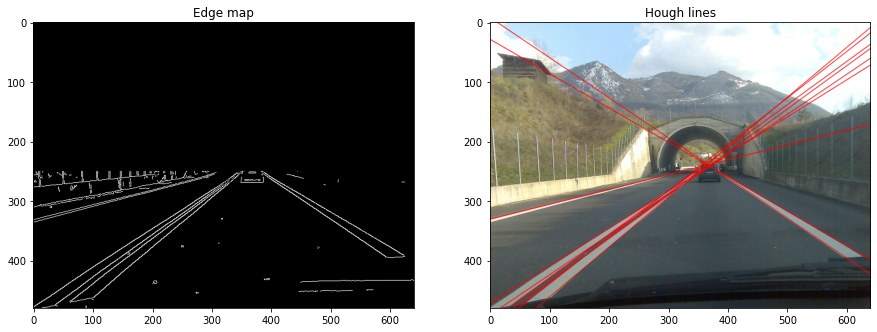

In [130]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [131]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1] * 180 / np.pi
    # Keep line if theta is not horizontal
    if abs(theta-90) > 20:
        filtered_lines.append(line)

(<AxesSubplot:title={'center':'Hough lines (filtered by angle)'}>,
 Text(0.5, 1.0, 'Hough lines (filtered by angle)'))

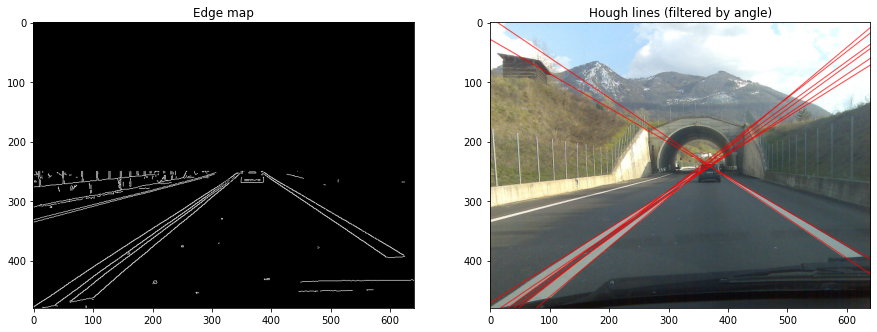

In [132]:
# Plot the resulting Filtered Hough lines
result = np.copy(img)
        
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines (filtered by angle)')

In [133]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[417.        ,   0.87266463],
       [ -7.        ,   2.16420817],
       [ 25.        ,   2.09439516],
       [406.33333333,   0.94247778],
       [399.        ,   1.01229095],
       [411.        ,   0.94247776]])

(<AxesSubplot:title={'center':'Hough lines (filtered by k-means)'}>,
 Text(0.5, 1.0, 'Hough lines (filtered by k-means)'))

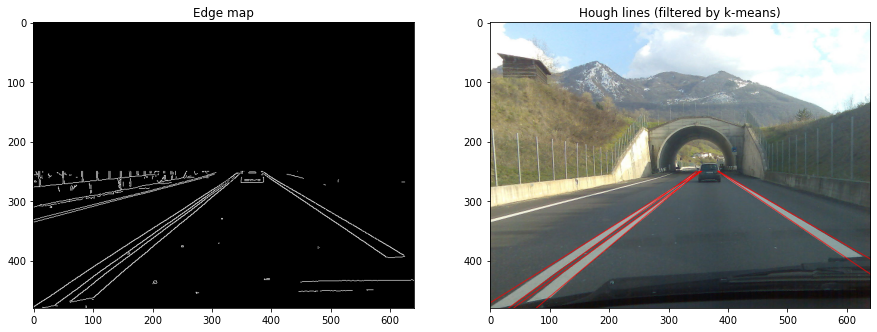

In [134]:
# Plot the resulting Filtered Hough lines
result = np.copy(img)
        
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

result[0:250,:] = img[0:250,:]
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines (filtered by k-means)')

*Answers*

1. Since the final result is a mathematical model of an infinite line, when it is superimposed on the image, it continues even where the edge along which it was detected ended. This can be a problem when detecting segments of arbitrary length. In general, this implementation is not robust and is very sensitive to any changes, such as: input data, image size, parameters of the edge detector and Hough transform.
2. The resolution is important parameter. The sensitivity of the Hough transform depends on this parameter. If it is too large, we can skip certain lines/segments, and if it is too small, on the contrary, take into account too many different small edges that may be unimportant or noisy.
3. The accumulator threshold is important parameter. With this parameter, we can control the minimum number of points that form a line and thus filter out small segments.
